# Import Packages

In [758]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import sys
import os
import math

import seaborn as sns
sns.set_style('white')
sns.set_context("paper")

from scipy.optimize import curve_fit

# Gaussian Processes
import gpflow
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float
from gpflow.utilities import set_trainable

# Tensorflow
import tensorflow as tf
import tensorflow_probability as tfp

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

from ev_forecasting_package.data_processing.VehicleRegistrationDataProcessing import VehicleStockModelDataPrepper
from ev_forecasting_package.models.VehicleStockDynamics import VehicleStockDynamicsInferenceModel

# Probit Transform Function Definitions

In [5]:
def probit(p):
    from scipy.stats import norm
    p = np.clip(p, 0.001, 0.999)
    return norm.ppf(p)

def invprobit(X):
    from scipy.stats import norm
    return norm.cdf(X)

In [436]:
def apply_invprobit_to_mean_and_variance(mean, variance):
    from scipy.stats import norm
    """Apply inverse probit transformation to mean and adjust variance."""
    transformed_mean = invprobit(mean)  # Apply inverse probit
    # Compute the variance transformation using the derivative of invprobit
    normal_pdf = norm.pdf(mean)  # φ(mean)
    transformed_variance = (normal_pdf ** 2) * variance  # Delta method
    return transformed_mean, transformed_variance.numpy()

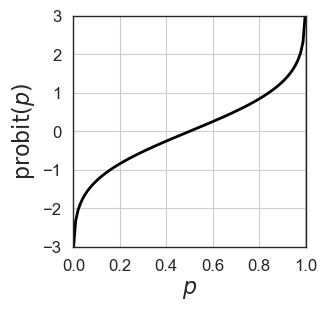

In [759]:
plt.figure(figsize=(3, 3))
probit_x = np.linspace(0, 1, 100)
plt.plot(
    probit_x,
    probit(probit_x),
    c='black',
    lw=2,
)
plt.xlim(-0.001, 1.001)
plt.ylim(-3, 3)
plt.xlabel(r'$p$', fontsize=16)
plt.ylabel(r'$\mathrm{probit}(p)$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

# Training data

We want to model four key variables using four individual Gaussian process (GP) models. These variables include:
- EV share of vehicle additions ($a$)
- BEV share of EV additions ($b$)
- Vehicle additions ($A_\text{Vehicles}$)
- Vehicle removals ($R_\text{Vehicles}$)

These variables can be described using time series data.

### Prepare the vehicle stock model data

In [7]:
vehicle_stock_model_data_prepper = VehicleStockModelDataPrepper()
year_quarter = '2023_Q4'
file_names = {
    'stock_eng': f'stock_df_{year_quarter}.csv',
    'additions_eng': f'sales_df_{year_quarter}.csv',
    'v_lsoa': f'v_lsoa_{year_quarter}.csv',
    'icev_lsoa': f'icev_lsoa_{year_quarter}.csv',
    'ev_lsoa': f'ev_lsoa_{year_quarter}.csv',
    'bev_lsoa': f'bev_lsoa_{year_quarter}.csv',
    'phev_lsoa': f'phev_lsoa_{year_quarter}.csv'
}
vehicle_stock_model_data_prepper.prepare_data(
    data_path='../data/large_datasets/vehicle_registrations/processed_data', 
    file_names=file_names, 
    lsoa_subset=115, 
    t_0=2012, # 
    t_0_raw=2011, 
    t_n=2023
)

### Generate LSOA-indexed data from "annual_data_dict"

We create a dictionary of Pandas DataFrames where we will eventually add the posterior means of the inferred vehicle stock dynamics.

In [461]:
lsoa_idxs = vehicle_stock_model_data_prepper.annual_data_dict['v_lsoa'].columns
data_dict = {}
for vehicle_type in ['v_lsoa', 'icev_lsoa', 'ev_lsoa', 'bev_lsoa', 'phev_lsoa', 'ev_market_share', 'bev_market_share', 'phev_market_share']:
    for lsoa in lsoa_idxs:
        if lsoa not in data_dict:
            data_dict[lsoa] = pd.DataFrame()
        data_dict[lsoa][vehicle_type] = vehicle_stock_model_data_prepper.annual_data_dict[vehicle_type][lsoa]

data_dict[lsoa_idxs[0]]

,v_lsoa,icev_lsoa,ev_lsoa,bev_lsoa,phev_lsoa,ev_market_share,bev_market_share,phev_market_share
Year,,,,,,,,
2011,391.0,391.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2012,386.0,386.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2013,369.0,369.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2014,362.0,362.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2015,356.0,356.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2016,356.0,355.0,1.0,1.0,0.0,0.002809,0.002809,0.000000
2017,358.0,356.0,2.0,2.0,0.0,0.005587,0.005587,0.000000
2018,368.0,366.0,3.0,3.0,0.0,0.008152,0.008152,0.000000
2019,364.0,360.0,4.0,4.0,0.0,0.010989,0.010989,0.000000


### Build the vehicle stock dynamics inference model

In [8]:
vehicle_stock_dynamics_inference_model = VehicleStockDynamicsInferenceModel(
    model_variables_dict=vehicle_stock_model_data_prepper.model_variables_dict, 
    annual_data_dict=vehicle_stock_model_data_prepper.annual_data_dict, 
    lsoa_idxs=vehicle_stock_model_data_prepper.lsoa_subset
)

vehicle_stock_dynamics_inference_model.build_model()

Model built successfully


### Load pre-run MCMC trace

In [9]:
vehicle_stock_dynamics_inference_model.load_trace('vehicle_stock_dynamics_model_banes_trace.nc')

Trace loaded from vehicle_stock_dynamics_model_banes_trace.nc


### Extract posterior means from loaded trace

In [10]:
posterior_means = vehicle_stock_dynamics_inference_model.calculate_posterior_means()

Posterior means calculated successfully


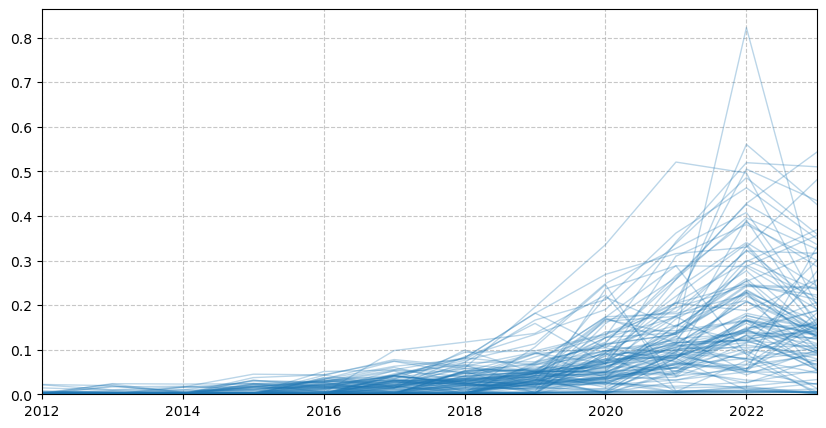

In [11]:
posterior_means['a'].plot(
    figsize=(10, 5),
    color='C0',
    alpha=0.3,
    lw=1,
    legend=False
    )

plt.xlim(left=2012, right=2023)
plt.ylim(bottom=0)
plt.grid(linestyle='--', alpha=0.7)

# Developing the mean function for EV share of vehicle additions ($a$)

<Axes: >

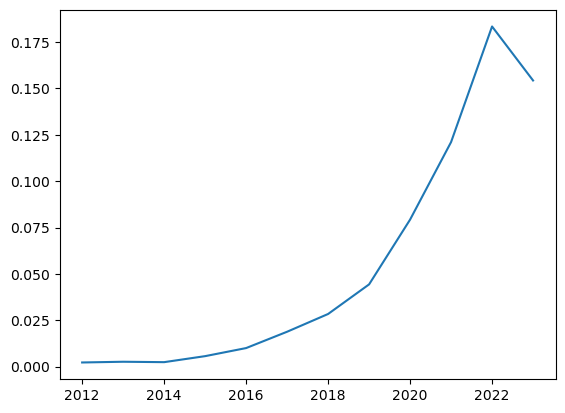

In [12]:
X = posterior_means['a'].index.values.reshape(-1, 1)
Y = posterior_means['a'].mean(axis=1).values.reshape(-1, 1)
test_data = pd.Series(index=X.flatten(), data=Y.flatten())
test_data.plot()

### Finding good initial parameters

Create a generalised logistic growth function to be fit to the mean of the posterior means.

In [12]:
def generalised_logistic_growth_init(X: tuple[int, pd.Series], v: float, Q: float, M: float, B: float) -> np.ndarray:
    t = X[0]
    data = X[1]
    K = 1*data.max()
    A = data.min()
    C = 1
    return A + ((K - A) / (C + Q * np.exp(-B * (t - M))) ** (1 / v))

Below is a function that fits a model/curve to observed data.

In [13]:
def fit_curve(data: pd.Series, model, t0, t_n, p0):
    T = data.index.values - t0
    condition1 = (data.index >= 0) & (data.index <= (t_n - t0))
    condition2 = (data.index >= (2024 - t0))
    data = data[condition1 | condition2]
    try:
        parameters, covariance = curve_fit(model, (T, data), data, p0, bounds=([0, -np.inf, 0, 0], [1, np.inf, np.inf, 1]), maxfev=5000) # New Bounds 16/09/24
        return parameters
    except RuntimeError as e:
        print(f"Error fitting curve")
        return None

Incorportate UK government mandates on new EV sales.

In [14]:
test_data[2024] = 0.22
test_data[2030] = 0.8
test_data[2035] = 1

fit_curve(test_data, generalised_logistic_growth_init, t0 = 2012, t_n = 2023, p0 = [1, 1, 1, 0.3])

array([ 1.        ,  4.42744423, 11.0272643 ,  0.40752699])

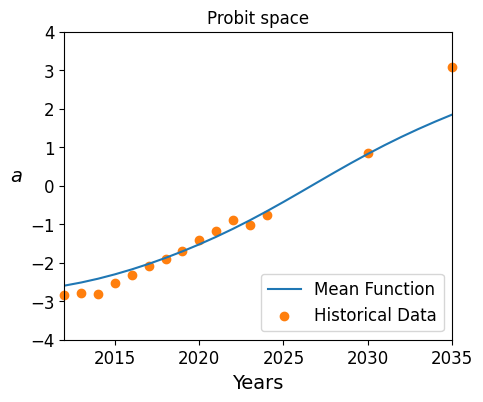

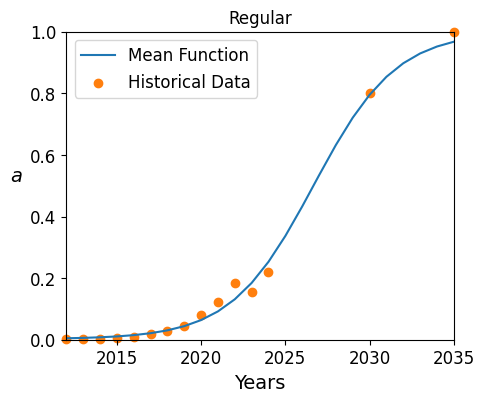

In [15]:
t_h = 2035
t_n = 2020
t_0 = 2012
glg_model_test = generalised_logistic_growth_init([np.arange(0, int((t_h - t_0)) + 1), test_data.values], v=1., Q=14.9471755, M=8.04170237, B=0.40752714)
# glg_model_test = generalised_logistic_growth_init([np.arange(0, int((t_h - t_0)) + 1), test_data.values], v=1., Q=10., M=5., B=0.3)

# Probit-transformed
plt.figure(figsize=(5, 4))
plt.plot(np.arange(2012, t_h + 1), probit(glg_model_test), label='Mean Function')
plt.scatter(x=test_data.index, y=probit(test_data), c='C1', clip_on=False, label='Historical Data')
plt.xlim(t_0, t_h)
plt.ylim(-4, 4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('$a$', fontsize=14, rotation=0, labelpad=10)
plt.legend(loc='lower right', ncol=1, fontsize=12)
plt.title('Probit space')
plt.show()

# Regular
plt.figure(figsize=(5, 4))
plt.plot(np.arange(2012, t_h + 1), glg_model_test, label='Mean Function')
plt.scatter(x=test_data.index, y=test_data, c='C1', clip_on=False, label='Historical Data')
plt.xlim(t_0, t_h)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('$a$', fontsize=14, rotation=0, labelpad=10)
plt.legend(loc='upper left', ncol=1, fontsize=12)
plt.title('Regular')
plt.show()

### Custom mean function

In [13]:
class GLGModel():
    def __init__(self, data) -> None:
        self.data = data
        self.fitted_params = None
        self.projection= None
    
    def glg(self, x: float | int | np.ndarray, K: float | int, A: float | int, v: float | int, Q: float | int, M: float | int, B: float | int, C=1):
        """
        Generalized logistic growth function.

        The Generalized Logistic Growth (GLG) function is defined as:

            f(x) = A + ((K - A) / (C + Q * exp(-B * (x - M)))^(1 / v))

        where:
            - K: Upper asymptote
            - A: Lower asymptote
            - v: Shape parameter controlling the growth rate
            - Q: Parameter to be fitted
            - M: Parameter representing the inflection point
            - B: Growth rate parameter
            - C: Constant (default is 1)

        Parameters:
            x: Input values (scalar or numpy array)
            K: Upper asymptote
            A: Lower asymptote
            v: Shape parameter 
            Q: Scaling parameter 
            M: Inflection point 
            B: Growth rate parameter
            C: Constant (default is 1)

        Returns:
            Logistic growth value at x.
        """
        return A + ((K - A) / (C + Q * np.exp(-B * (x - M))) ** (1 / v))

    def fit_curve(self, t_0: int, t_n: int, p0: list | np.ndarray) -> list | None:
        """
        Fit the logistic growth function to the data. The curve is fitted for x values that are translated long the x-axis by t_0. 
        
        Parameters:
            t_0: starting time offset
            t_n: ending time for fitting
            p0: initial guess for parameters [v, Q, M, B]
            
        Returns:
            Fitted parameters or None if fitting fails.
        """
        condition1 = (self.data.index >= 0) & (self.data.index <= (t_n - t_0))
        condition2 = (self.data.index >= (2024 - t_0))
        data_subset = self.data[condition1 | condition2]
        T = data_subset.index.values - t_0
        try:
            parameters, _ = curve_fit(
                lambda t, v, Q, M, B: self.glg(t, self.data.max(), self.data.min(), v, Q, M, B),
                T, 
                data_subset, 
                p0, 
                bounds=([0, -np.inf, 0, 0], [1, np.inf, np.inf, 1]), 
                maxfev=5000
            )
            self.fitted_params = parameters
            return parameters
        except RuntimeError as e:
            print(f"Error fitting curve: ", e)
            return None
    
    def project(self, t_0: int, t_n: int, t_h: int) -> pd.Series | None:
        """
        Projects the logistic growth forward based on the fitted parameters.
        
        Parameters:
            t_0: starting time offset
            t_n: ending time for fitting
            t_h: horizon time for projection
            
        Returns:
            A pandas Series with the projected values.
        """
        params = self.fit_curve(t_0, t_n, p0=[1, 1, 1, 0.3])
        if params is None:
            return None
        
        F = np.arange(0, int(t_h - t_0) + 1)
        projection = self.glg(F, self.data.max(), self.data.min(), *params)
        self.projection = pd.Series(
            index=F + t_0,
            data=projection,
            name='projection'
        )
        return self.projection

    def evaluate(self, X):
        """
        Evaluate the fitted generalised logistic growth function at given input X. 
        
        X is relative to t_0, so if t_0 = 2012, then X would need to be 8 to represent 2020.

        A probit transformation is applied to the result.
        
        Parameters:
            X: input values
            
        Returns:
            Evaluated mean function. You can apply a probit (or other transformation)
            here if needed.
        """
        if self.fitted_params is None:
            raise ValueError("The model has not been fitted yet.")
        v, Q, M, B = self.fitted_params # B
        glg_value = self.glg(X, self.data.max(), self.data.min(), v, Q, M, B)
        return probit(glg_value)

Testing the GLG model

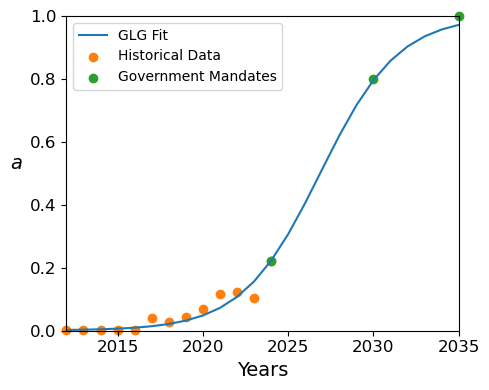

In [21]:
t_h = 2035
t_n = 2023
t_0 = 2012

test_data = pd.Series(index=np.arange(t_0, t_n+1), data=posterior_means['a'].loc[t_0:t_n].iloc[:, 3].values)

# Government mandates
test_data[2024] = 0.22
test_data[2030] = 0.8
test_data[2035] = 1

glg_model_test = GLGModel(data=test_data)
projection = glg_model_test.project(t_0=t_0, t_n=t_n, t_h=t_h)

plt.figure(figsize=(5, 4))
plt.plot(np.arange(t_0, t_h + 1), projection, label='GLG Fit')
plt.scatter(x=test_data.loc[:2024].index, y=test_data.loc[:2024], c='C1', clip_on=False, label='Historical Data')
plt.scatter(x=test_data.loc[2024:].index, y=test_data.loc[2024:], c='C2', clip_on=False, label='Government Mandates')
plt.xlim(t_0, t_h)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('$a$', fontsize=14, rotation=0, labelpad=10)
plt.legend(loc='upper left', ncol=1, fontsize=10)
plt.tight_layout()
plt.show()

In [22]:
invprobit(glg_model_test.evaluate(17))

0.7164275869380332

Custom mean function wrapper

In [20]:
class CustomMeanFunction(gpflow.mean_functions.MeanFunction):
    def __init__(self, custom_mean_function):
        super().__init__()
        self.custom_mean_function = custom_mean_function

    def __call__(self, X):
        X = tf.cast(X, dtype=tf.float64)
        X_np = X.numpy()
        mean_values = self.custom_mean_function.evaluate(X_np)
        return tf.convert_to_tensor(mean_values, dtype=tf.float64)

# Building the forecasting model

### New EV Forecasting Model Class

In [993]:
import copy

class EVForecastingModel:
    def __init__(self, lsoa_idx: str, data: pd.DataFrame, kernels: dict, mean_functions: dict, likelihoods: dict, t: dict):
        self.lsoa_idx = lsoa_idx
        self.data = data
        self.processed_data = {}
        self.kernels = kernels
        self.mean_functions = mean_functions
        self.likelihoods = likelihoods
        self.t_0 = t['t_0']
        self.t_n = t['t_n']
        self.t_h = t['t_h']
        self.gp_models = {}
        self.gp_models_trained = {}
        self.f_dict = {}
        self.f_samples_dict = {}
        self.forecasts = {}
        self._prepare_training_data()
        self._construct_gp_models()

    def _train_single_model(self, model):
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model.training_loss, model.trainable_variables)
        return model

    def train_models(self):
        for var, model in self.gp_models.items():
            self.gp_models_trained[var] = self._train_single_model(model) 
            print(f'GP for variable: {var} trained successfully')
        pass

    # def predict_f(self, Xnew: np.ndarray) -> dict:
    #     for var, model in self.gp_models_trained.items():
    #         f_raw = model.predict_f(Xnew)
    #         if var in ['a', 'b']:
    #             mean, variance = invprobit(f_raw)
    #         elif var in ['A', 'R']:
    #             mean, variance = model.likelihood.invlink(f_raw).numpy()
    #         moments = {
    #             'mean': mean,
    #             'variance': variance
    #         }
    #         self.f_dict[var] = moments
    #     return self.f_dict

    def predict_f(self, Xnew: np.ndarray) -> dict:
        for var, model in self.gp_models_trained.items():
            f_raw, var_raw = model.predict_f(Xnew)  # Get GP predictions
            if var in ['a', 'b']:
                mean, variance = apply_invprobit_to_mean_and_variance(f_raw, var_raw)  # Apply probit transformation
            elif var in ['A', 'R']:
                mean, variance = model.likelihood.invlink([f_raw, var_raw]).numpy()
            moments = {
                'mean': mean,
                'variance': variance
            }
            self.f_dict[var] = moments
        return self.f_dict
    
    def generate_f_samples(self, n_samples=1000, return_dict=True):
        for var, model in self.gp_models_trained.items():
            Xnew = np.arange(0, self.t_h - self.t_0 + 1).reshape(-1, 1).astype(np.float64)
            idx = np.arange(self.t_0, self.t_h + 1)
            f_samples_raw = model.predict_f_samples(Xnew, num_samples=n_samples)[:, :, 0].numpy().T
            if var in ['a', 'b']:
                f_samples = invprobit(f_samples_raw)
            elif var in ['A', 'R']:
                f_samples = model.likelihood.invlink(f_samples_raw)
            elif model.likelihood.name == 'gaussian':
                f_samples = f_samples_raw
            self.f_samples_dict[var] = pd.DataFrame(data=f_samples, index=idx)
        print(f"{n_samples} samples taken from each GP model.")
        if return_dict:
            return self.f_samples_dict
        else:
            pass
    
    def _prepare_training_data(self) -> dict:
        X_train = (np.arange(self.t_0, self.t_n + 1) - self.t_0).reshape(-1, 1).astype(np.float64)
        for key, data in self.data.items():
            data_slice = data.loc[self.t_0:self.t_n]
            Y_train = data_slice.to_numpy().reshape(-1, 1).astype(np.float64)
            if key == 'a':
                Y_train = probit(Y_train)
            data_train = (tf.constant(X_train, dtype=tf.float64), tf.constant(Y_train, dtype=tf.float64))
            self.processed_data[key] = data_train
        print('GP training data prepared successfully')
        pass
    
    def _construct_gp_models(self):
        self.gp_models['a'] = self._construct_a_gp_model()
        self.gp_models['b'] = self._construct_b_gp_model()
        self.gp_models['A'] = self._construct_A_gp_model()
        self.gp_models['R'] = self._construct_R_gp_model()
        print('GP models constructed successfully')
        pass

    def _construct_a_gp_model(self):
        a_gp_model = gpflow.models.GPR(
            data=self.processed_data['a'],
            kernel=copy.deepcopy(self.kernels['a']), # Use deepcopy to avoid kernel contamination
            mean_function=self.mean_functions['a']
        )
        a_gp_model.likelihood.variance = gpflow.Parameter(f64(0.4), prior=tfp.distributions.Gamma(f64(2.0), f64(5.0)), transform=tfp.bijectors.Softplus())
        return a_gp_model

    def _construct_b_gp_model(self):
        b_gp_model = gpflow.models.VGP(
            data=self.processed_data['b'],
            kernel=copy.deepcopy(self.kernels['b']), # Use deepcopy to avoid kernel contamination
            mean_function=self.mean_functions['b'],
            likelihood=self.likelihoods['b']
        )
        set_trainable(b_gp_model.mean_function.c, False)
        return b_gp_model

    def _construct_A_gp_model(self):
        A_gp_model = gpflow.models.VGP(
            data=self.processed_data['A_vehicles'],
            kernel=copy.deepcopy(self.kernels['A_vehicles']), # Use deepcopy to avoid kernel contamination
            mean_function=self.mean_functions['A_vehicles'],
            likelihood=self.likelihoods['A_vehicles']
        )
        set_trainable(A_gp_model.mean_function.c, False)
        return A_gp_model

    def _construct_R_gp_model(self):
        R_gp_model = gpflow.models.VGP(
            data=self.processed_data['R_vehicles'],
            kernel=copy.deepcopy(self.kernels['R_vehicles']), # Use deepcopy to avoid kernel contamination
            mean_function=self.mean_functions['R_vehicles'],
            likelihood=self.likelihoods['R_vehicles']
        )
        set_trainable(R_gp_model.mean_function.c, False)
        return R_gp_model
    
    # Forecasting
    def generate_forecasts(self):
        self._forecast_ev_stock()
        self._forecast_bev_stock()
        self._forecast_phev_stock()
        self._calculate_ev_market_share()
        self._calculate_bev_market_share()
        self._calculate_phev_market_share()
        print("Forecasts generated successfully.")

    def _forecast_ev_additions(self):
        self.forecasts['A'] = self.f_samples_dict['A'].loc[self.t_0:]
        self.forecasts['R'] = self.f_samples_dict['R'].loc[self.t_0:]
        self.f_samples_dict['A_ev'] = self.f_samples_dict['a'] * self.f_samples_dict['A']
        self.forecasts['a'] = self.f_samples_dict['a'].loc[self.t_0:]
        self.forecasts['A_ev'] = self.f_samples_dict['A_ev'].loc[self.t_0:]
        return self.forecasts['A_ev'].loc[self.t_n + 1:]

    def _forecast_bev_additions(self):
        self.forecasts['b'] = self.f_samples_dict['b'].loc[self.t_0:]
        self.f_samples_dict['A_bev'] = self.f_samples_dict['b'] * self.f_samples_dict['A_ev']
        self.forecasts['A_bev'] = self.f_samples_dict['A_bev'].loc[self.t_0:]
        return self.forecasts['A_bev'].loc[self.t_n + 1:]

    def _forecast_phev_additions(self):
        self.f_samples_dict['1-b'] = 1 - self.f_samples_dict['b']
        self.forecasts['1-b'] = self.f_samples_dict['1-b'].loc[self.t_0:]
        self.f_samples_dict['A_phev'] = self.f_samples_dict['1-b'] * self.f_samples_dict['A_ev']
        self.forecasts['A_phev'] = self.f_samples_dict['A_phev'].loc[self.t_0:]
        return self.forecasts['A_phev'].loc[self.t_n + 1:]

    def _forecast_total_vehicle_stock(self):
        additions_cumulative = self.f_samples_dict['A'].loc[self.t_n + 1:].cumsum(axis=0)
        removals_cumulative = self.f_samples_dict['R'].loc[self.t_n + 1:].cumsum(axis=0)
        initial_stock = self.data['v_lsoa'].loc[self.t_n]
        v_stock_projected = initial_stock + additions_cumulative - removals_cumulative
        v_stock_projected = v_stock_projected.clip(0, np.inf)
        v_stock_projected.loc[self.t_n, :] = initial_stock
        v_stock_projected.sort_index(inplace=True)
        self.forecasts['V'] = v_stock_projected
        return self.forecasts['V']

    def _forecast_removal_rates(self):
        vehicle_stock_forecast = self._forecast_total_vehicle_stock()
        self.f_samples_dict['r'] = (self.f_samples_dict['R'] / vehicle_stock_forecast).clip(0, 1)
        self.forecasts['r'] = (self.f_samples_dict['R'].loc[self.t_n + 1:] / vehicle_stock_forecast.loc[self.t_n + 1:]).clip(0, 1)
        return self.forecasts['r']

    def _forecast_stock(self, additions_forecast, initial_stock_key, stock_forecast_key):
        removal_rates_forecast = self._forecast_removal_rates()
        initial_stock = self.data[initial_stock_key].loc[self.t_n]
        stock_forecast = additions_forecast.copy()

        for column in additions_forecast.columns:
            stock = initial_stock
            for year in additions_forecast.index:
                stock += additions_forecast.at[year, column]
                removals = stock * removal_rates_forecast.at[year, column]
                stock -= removals
                stock_forecast.at[year, column] = stock

        stock_forecast.loc[self.t_n, :] = initial_stock
        stock_forecast.sort_index(inplace=True)
        self.forecasts[stock_forecast_key] = round(stock_forecast)
        return self.forecasts[stock_forecast_key]

    def _forecast_ev_stock(self):
        return self._forecast_stock(self._forecast_ev_additions(), 'ev_lsoa', 'EV')

    def _forecast_bev_stock(self):
        return self._forecast_stock(self._forecast_bev_additions(), 'bev_lsoa', 'BEV')

    def _forecast_phev_stock(self):
        return self._forecast_stock(self._forecast_phev_additions(), 'phev_lsoa', 'PHEV')

    def _calculate_market_share(self, vehicle_type):
        share_key = f"{vehicle_type}_MS"
        stock_key = f"{vehicle_type}"
        self.forecasts[share_key] = self.forecasts[stock_key] / self.forecasts['V']
        return self.forecasts[share_key]

    def _calculate_ev_market_share(self):
        return self._calculate_market_share('EV')

    def _calculate_bev_market_share(self):
        return self._calculate_market_share('BEV')

    def _calculate_phev_market_share(self):
        return self._calculate_market_share('PHEV')
    
    def plot_forecast(self, variable_name, y_lim_max=None):
        if variable_name not in self.forecasts:
            raise ValueError(f"Variable name '{variable_name}' not found in forecasts. Choose from {list(self.forecasts.keys())}")

        forecast = self.forecasts[variable_name]
        X_test = np.arange(self.t_n, self.t_h + 1).astype(np.float64)

        data_sources = {
            'V': ('v_lsoa', 'Projected Vehicle Stock for LSOA: ', 'Vehicles'),
            'EV': ('ev_lsoa', 'Projected EV Stock for LSOA: ', 'Vehicles'),
            'BEV': ('bev_lsoa', 'Projected BEV Stock for LSOA: ', 'Vehicles'),
            'PHEV': ('phev_lsoa', 'Projected PHEV Stock for LSOA: ', 'Vehicles'),
            'EV_MS': ('ev_market_share', 'Projected EV Market Share for LSOA: ', 'Share'),
            'BEV_MS': ('bev_market_share', 'Projected BEV Market Share for LSOA: ', 'Share'),
            'PHEV_MS': ('phev_market_share', 'Projected PHEV Market Share for LSOA: ', 'Share'),
            'ICEV': ('icev_lsoa', 'Projected ICEV Stock for LSOA: ', 'Vehicles'),
            'A': ('A_vehicles', 'Projected Vehicle Additions for LSOA: ', 'Vehicles'),
            'R': ('R_vehicles', 'Projected Vehicle Removals for LSOA: ', 'Vehicles'),
            'a': ('a', 'Projected EV Share of Vehicle Additions for LSOA: ', 'Share'),
            'A_ev': ('A_ev', 'Projected EV Additions for LSOA: ', 'Vehicles'),
            'b': ('b', 'Projected BEV Share of EV Additions for LSOA: ', 'Share'),
            'A_bev': ('A_bev', 'Projected BEV Additions for LSOA: ', 'Vehicles'),
            '1-b': ('1-b', 'Projected PHEV Share of EV Additions for LSOA: ', 'Share'),
            'A_phev': ('A_phev', 'Projected PHEV Additions for LSOA: ', 'Vehicles')
        }

        if variable_name not in data_sources:
            raise ValueError(f"Variable name '{variable_name}' not found.")

        data_key, title_prefix, unit = data_sources[variable_name]

        if variable_name in ['V', 'EV', 'BEV', 'PHEV', 'ICEV', 'EV_MS', 'BEV_MS', 'PHEV_MS']:
            data_historical = self.data[data_key].loc[self.t_0:self.t_n]
            data_test = self.data[data_key].loc[self.t_n:]
        else:
            X_test = np.arange(self.t_0, self.t_h + 1).astype(np.float64)
            data_historical = self.data[data_key].loc[self.t_0:self.t_n]
            data_test = self.data[data_key].loc[self.t_n:]

        plot_title = f'{title_prefix}{self.lsoa_idx}'

        lower_bound = forecast.quantile(0.025, axis=1).values
        upper_bound = forecast.quantile(0.925, axis=1).values
        lower_q = forecast.quantile(0.25, axis=1).values
        upper_q = forecast.quantile(0.75, axis=1).values
        median_forecast = forecast.quantile(0.5, axis=1).values

        if y_lim_max is None:
            y_lim_max = max(1.1 * upper_bound.max(), 1.1 * data_historical.max())

        plt.figure(figsize=(5, 3))

        # plt.scatter(data_historical.index, data_historical.values, c='C1', s=20, zorder=5, label='Training Data', alpha=0.9, clip_on=False)
        # plt.scatter(data_test.index, data_test.values, c='C2', s=20, zorder=5, label='Test Data', alpha=0.9, clip_on=False)
        plt.plot(data_historical.index, data_historical.values, c='C1', lw=1, zorder=5, label='Training Data', alpha=0.8, clip_on=False)
        plt.plot(data_test.index, data_test.values, c='C2', lw=1, zorder=5, label='Test Data', alpha=0.8, clip_on=False)
        plt.fill_between(X_test, lower_bound, upper_bound, color='C0', alpha=0.1, label='95% PI')
        plt.fill_between(X_test, lower_q, upper_q, color='C0', alpha=0.3, label='50% PI')
        plt.plot(X_test, forecast.mean(axis=1), 'black', lw=1, linestyle='--', label='Mean')
        plt.plot(X_test, median_forecast, 'black', lw=1, label='Median')
        plt.vlines(x=data_historical.index[-1], ymin=0, ymax=y_lim_max, color='grey', linestyles='--', alpha=1, label='t_n')

        plt.title(plot_title)
        plt.xlim(min(X_test[0], data_historical.index.min()), max(X_test[-1], data_historical.index.max()))
        if math.isnan(y_lim_max):
            y_lim_max = 1
        plt.ylim(0, y_lim_max)
        plt.xlabel('Year')
        plt.ylabel(unit)
        plt.grid(axis='both', alpha=0.7, linestyle='--')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

Add posterior means of the four variables to be forecasted to the data dictionary containing historical data for vehicle registrations.

In [971]:
for key in posterior_means.keys():
    for lsoa in lsoa_idxs:
        data_dict[lsoa][key] = posterior_means[key][lsoa]

data_dict[lsoa_idxs[0]]

,v_lsoa,icev_lsoa,ev_lsoa,bev_lsoa,phev_lsoa,ev_market_share,bev_market_share,phev_market_share,A_vehicles,R_vehicles,A_ev,R_ev,A_bev,R_bev,A_phev,R_phev,a,b,1 - b
Year,,,,,,,,,,,,,,,,,,,
2011,391.0,391.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,386.0,386.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,16.75,21.75,0.062515,0.000000,0.031775,0.000000,0.030740,0.000000,0.003883,0.504743,0.495257
2013,369.0,369.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,14.25,31.25,0.061607,0.000000,0.031635,0.000000,0.029972,0.000000,0.004836,0.506840,0.493160
2014,362.0,362.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,18.25,25.25,0.062146,0.000000,0.030801,0.000000,0.031345,0.000000,0.003499,0.494931,0.505069
2015,356.0,356.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,22.25,28.25,0.061711,0.000000,0.030472,0.000000,0.031238,0.000000,0.002796,0.496227,0.503773
2016,356.0,355.0,1.0,1.0,0.0,0.002809,0.002809,0.000000,21.50,21.50,1.086745,0.060393,1.023015,0.060393,0.063730,0.000000,0.051072,0.941975,0.058025
2017,358.0,356.0,2.0,2.0,0.0,0.005587,0.005587,0.000000,21.00,19.00,1.132853,0.106145,1.069082,0.106145,0.063772,0.000000,0.054561,0.944319,0.055681
2018,368.0,366.0,3.0,3.0,0.0,0.008152,0.008152,0.000000,22.75,12.75,1.130339,0.103940,1.066106,0.103940,0.064232,0.000000,0.049853,0.943844,0.056156
2019,364.0,360.0,4.0,4.0,0.0,0.010989,0.010989,0.000000,18.25,22.25,1.270816,0.244505,1.207551,0.244505,0.063265,0.000000,0.070183,0.950696,0.049304


In [972]:
# idx = 0

# data_dict = {
#     'a': posterior_means['a'].iloc[:, idx],
#     'b': posterior_means['b'].iloc[:, idx],
#     'A_vehicles': posterior_means['A_vehicles'].iloc[:, idx],
#     'R_vehicles': posterior_means['R_vehicles'].iloc[:, idx]
# }

Take data for one LSOA

In [1051]:
idx = 2
data = data_dict[lsoa_idxs[idx]]

Create time horizon parameters

In [1052]:
t_dict = {
    't_0': 2012,
    't_n': 2020,
    't_h': 2035
}

Constructing GP kernel priors

In [1053]:
# 'a' kernel
a_rbf_kernel = gpflow.kernels.RBF(
    lengthscales=gpflow.Parameter(f64(3.0), prior=tfp.distributions.Gamma(f64(10.0), f64(2.0)), transform=tfp.bijectors.Softplus()),
    variance=gpflow.Parameter(f64(0.5), prior=tfp.distributions.Gamma(f64(2), f64(1)), transform=tfp.bijectors.Softplus())
)
a_white_kernel = gpflow.kernels.White(variance=0.05)
gpflow.set_trainable(a_white_kernel.variance, False) # Fix variance of white kernel
a_kernel = a_rbf_kernel + a_white_kernel

# 'b' kernel
b_rbf_kernel = gpflow.kernels.RBF(
    lengthscales=gpflow.Parameter(f64(3.0), prior=tfp.distributions.Gamma(f64(10.0), f64(2.0)), transform=tfp.bijectors.Softplus()),
    variance=gpflow.Parameter(f64(0.5), prior=tfp.distributions.Gamma(f64(2), f64(0.25)), transform=tfp.bijectors.Softplus())
)
b_white_kernel = gpflow.kernels.White(variance=0.05)
gpflow.set_trainable(b_white_kernel.variance, False) # Fix variance of white kernel
b_kernel = b_rbf_kernel + b_white_kernel

# 'A_vehicles' kernel
A_rbf_kernel = gpflow.kernels.RBF(
    lengthscales=gpflow.Parameter(f64(3.0), prior=tfp.distributions.Gamma(f64(10.0), f64(2.0)), transform=tfp.bijectors.Softplus()),
    variance=gpflow.Parameter(f64(0.5), prior=tfp.distributions.Uniform(low=tf.cast(0.05, tf.float64), high=tf.cast(10, tf.float64)), transform=tfp.bijectors.Softplus())
)
A_white_kernel = gpflow.kernels.White(variance=f64(0.01))
A_kernel = A_rbf_kernel + A_white_kernel

# 'R_vehicles' kernel
R_rbf_kernel = gpflow.kernels.RBF(
    lengthscales=gpflow.Parameter(f64(3.0), prior=tfp.distributions.Gamma(f64(10.0), f64(2.0)), transform=tfp.bijectors.Softplus()),
    variance=gpflow.Parameter(f64(0.5), prior=tfp.distributions.Uniform(low=tf.cast(0.05, tf.float64), high=tf.cast(10, tf.float64)), transform=tfp.bijectors.Softplus())
)
R_white_kernel = gpflow.kernels.White(variance=f64(0.01))
R_kernel = R_rbf_kernel + R_white_kernel

# Create kernel dictionary
kernels_dict = {
    'a': a_kernel,
    'b': b_kernel,
    'A_vehicles': A_kernel,
    'R_vehicles': R_kernel
}


Constructing mean functions

In [1054]:
# Fixed Model Parameters
t_0=t_dict['t_0']
t_n=t_dict['t_n']
t_h=t_dict['t_h']
govermnent_mandates = {
    2024: 0.22,
    2030: 0.8,
    2035: 1,
}

# 'a' mean function
X = data['a'].loc[t_0:t_n].index.values.reshape(-1, 1)
Y = data['a'].loc[t_0:t_n].values.reshape(-1, 1)
training_data = pd.Series(index=X.flatten(), data=Y.flatten())

# Government Mandates
for year, value in govermnent_mandates.items():
    training_data[year] = value

glg_model = GLGModel(data=training_data)
glg_model.project(t_0=t_0, t_n=t_n, t_h=t_h)
a_mean_function = CustomMeanFunction(glg_model)

# 'b' mean function
if (data['a'].loc[:t_n] > 0).sum() > 0:
    first_non_zero_year = data['a'][data['a'] > 0].index[0]
else:
    first_non_zero_year = t_0

constant_mean = f64(data['b'].loc[first_non_zero_year:t_n].mean() + 0.5*(1 - data['b'].loc[first_non_zero_year:t_n].mean()))
b_mean_function = gpflow.functions.Constant(probit(constant_mean))

# 'A_vehicles' mean function
A_mean_function = gpflow.functions.Constant(f64(np.log(data['A_vehicles'].mean())))

# 'R_vehicles' mean function
R_mean_function = gpflow.functions.Constant(f64(np.log(data['R_vehicles'].mean())))

mean_functions_dict = {
    'a': a_mean_function,
    'b': b_mean_function,
    'A_vehicles': A_mean_function,
    'R_vehicles': R_mean_function
}

Constructing likelihoods

In [1055]:
a_likelihood = None
b_likelihood = gpflow.likelihoods.Beta()
A_likelihood = gpflow.likelihoods.Poisson()
R_likelihood = gpflow.likelihoods.Poisson()

likelihoods_dict = {
    'a': a_likelihood,
    'b': b_likelihood,
    'A_vehicles': A_likelihood,
    'R_vehicles': R_likelihood
}

Initialising the forecasting model

In [1056]:
ev_forecasting_model = EVForecastingModel(
    lsoa_idx=lsoa_idxs[idx],
    data=data,
    kernels=kernels_dict,
    mean_functions=mean_functions_dict,
    likelihoods=likelihoods_dict,
    t=t_dict
)

GP training data prepared successfully
GP models constructed successfully


- Training the GP models
- Sample from them
- Generate EV/BEV/PHEV stock forecasts

In [1112]:
ev_forecasting_model.train_models()
ev_forecasting_model.generate_f_samples(return_dict=False, n_samples=1000)
ev_forecasting_model.generate_forecasts()

GP for variable: a trained successfully
GP for variable: b trained successfully
GP for variable: A trained successfully
GP for variable: R trained successfully
1000 samples taken from each GP model.
Forecasts generated successfully.


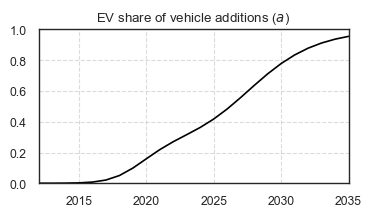

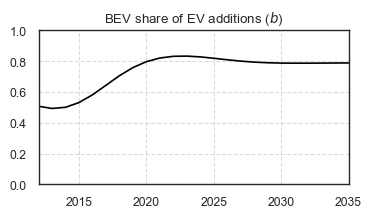

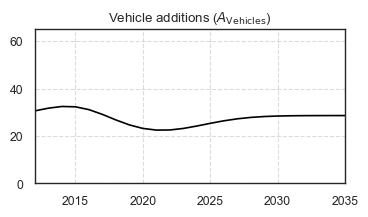

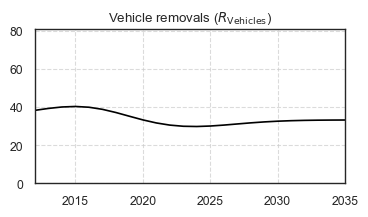

In [1093]:
Xnew = np.arange(0, 24, 1).reshape(-1, 1)
f_dict = ev_forecasting_model.predict_f(Xnew)

mean, variance = f_dict['a'].values()
plt.figure(figsize=(4, 2))
plt.plot(
    Xnew + t_dict['t_0'],
    mean,
    c='black'
    )
plt.grid(axis='both', alpha=0.7, linestyle='--')
plt.xlim(left=t_dict['t_0'], right=t_dict['t_h'])
plt.ylim(bottom=0, top=1)
plt.title(r'EV share of vehicle additions ($a$)')
plt.show()

mean, variance = f_dict['b'].values()
plt.figure(figsize=(4, 2))
plt.plot(
    Xnew + t_dict['t_0'],
    mean,
    c='black'
    )
plt.grid(axis='both', alpha=0.7, linestyle='--')
plt.xlim(left=t_dict['t_0'], right=t_dict['t_h'])
plt.ylim(bottom=0, top=1)
plt.title(r'BEV share of EV additions ($b$)')
plt.show()

mean, variance = f_dict['A'].values()
plt.figure(figsize=(4, 2))
plt.plot(
    Xnew + t_dict['t_0'],
    mean,
    c='black'
    )
plt.grid(axis='both', alpha=0.7, linestyle='--')
plt.xlim(left=t_dict['t_0'], right=t_dict['t_h'])
plt.ylim(bottom=0, top=2*np.max(mean))
plt.title(r'Vehicle additions ($A_\text{Vehicles}$)')
plt.show()

mean, variance = f_dict['R'].values()
plt.figure(figsize=(4, 2))
plt.plot(
    Xnew + t_dict['t_0'],
    mean,
    c='black'
    )
plt.grid(axis='both', alpha=0.7, linestyle='--')
plt.xlim(left=t_dict['t_0'], right=t_dict['t_h'])
plt.ylim(bottom=0, top=2*np.max(mean))
plt.title(r'Vehicle removals ($R_\text{Vehicles}$)')
plt.show()

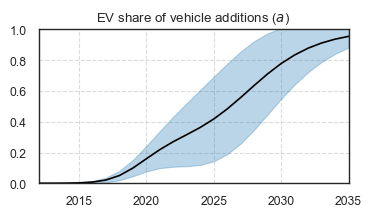

In [1094]:
Xnew = np.arange(0, 24, 1).reshape(-1, 1)
f_dict = ev_forecasting_model.predict_f(Xnew)

mean, variance = f_dict['a'].values()
mean = mean.reshape(1,-1)[0]
variance = variance.reshape(1,-1)[0]
std_dev = np.sqrt(variance)

plt.figure(figsize=(4, 2))
plt.plot(
    Xnew + t_dict['t_0'],
    mean,
    c='black'
    )
plt.fill_between(x=Xnew.reshape(1, -1)[0]+t_dict['t_0'], y1=mean-1*std_dev, y2=mean+1*std_dev, color='C0', alpha=0.3)
plt.grid(axis='both', alpha=0.7, linestyle='--')
plt.xlim(left=t_dict['t_0'], right=t_dict['t_h'])
plt.ylim(bottom=0, top=1)
plt.title(r'EV share of vehicle additions ($a$)')
plt.show()

100 samples taken from each GP model.


<Axes: >

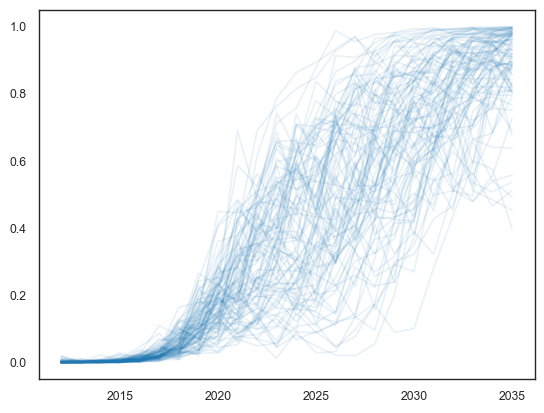

In [1095]:
ev_forecasting_model.generate_f_samples(n_samples=100)['a'].plot(legend=False, color='C0', alpha=0.1)

<Axes: >

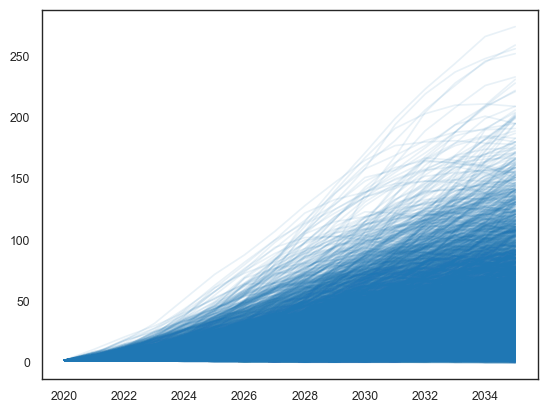

In [1096]:
ev_forecasting_model.forecasts['PHEV'].plot(legend=False, color='C0', alpha=0.1)

### Plotting Forecasts

In [1097]:
ev_forecasting_model.forecasts.keys()

dict_keys(['A', 'R', 'a', 'A_ev', 'V', 'r', 'EV', 'b', 'A_bev', 'BEV', '1-b', 'A_phev', 'PHEV', 'EV_MS', 'BEV_MS', 'PHEV_MS'])

In [1098]:
def plot_forecast(forecast_dict: dict, variable_name: str, normal: bool):
    if variable_name not in forecast_dict.keys():
        raise ValueError(f"Variable name '{variable_name}' not found.")
    forecast = forecast_dict[variable_name]
    forecast_years = forecast.index
    plt.figure(figsize=(6, 3))

    if normal:
        mean = forecast.mean(axis=1)
        std_dev = forecast.std(axis=1)
        plt.plot(
            forecast_years,
            mean,
            c='black',
            label='Mean'
        )
        plt.fill_between(x=forecast_years, y1=mean-2*std_dev, y2=mean+2*std_dev, color='C0', alpha=0.1, label=r'$\pm 2 \sigma$')
        plt.fill_between(x=forecast_years, y1=mean-std_dev, y2=mean+std_dev, color='C0', alpha=0.3, label=r'$\pm 1 \sigma$')

    if not normal:
        median = forecast.median(axis=1)
        p25 = forecast.quantile(0.25, axis=1)
        p75 = forecast.quantile(0.75, axis=1)
        p025 = forecast.quantile(0.025, axis=1)
        p975 = forecast.quantile(0.975, axis=1)

        plt.fill_between(x=forecast_years, y1=p025, y2=p975, color='C0', alpha=0.1, label='95th PI')
        plt.fill_between(x=forecast_years, y1=p25, y2=p75, color='C0', alpha=0.3, label='50th PI')
        plt.plot(
            forecast_years,
            median,
            c='black',
            label='Median'
        )

    plt.grid(axis='both', alpha=0.7, linestyle='--')
    plt.xlim(left=t_dict['t_n'], right=t_dict['t_h'])
    plt.ylim(bottom=0)
    plt.title(f'"{variable_name}" forecast')
    plt.legend()
    plt.show()
    

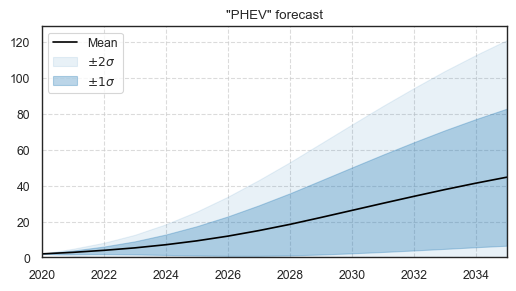

In [1099]:
plot_forecast(forecast_dict=ev_forecasting_model.forecasts, variable_name='PHEV', normal=True)

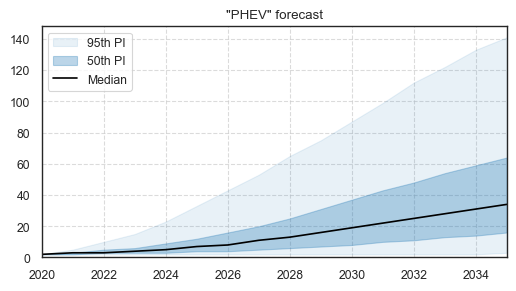

In [1100]:
plot_forecast(forecast_dict=ev_forecasting_model.forecasts, variable_name='PHEV', normal=False)

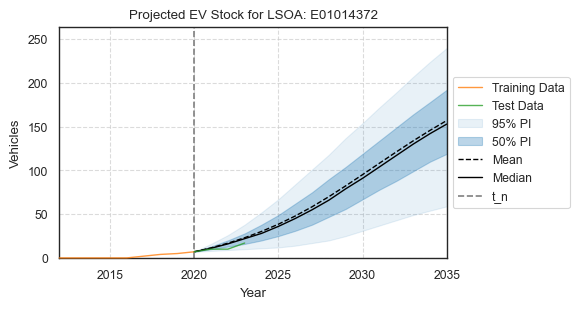

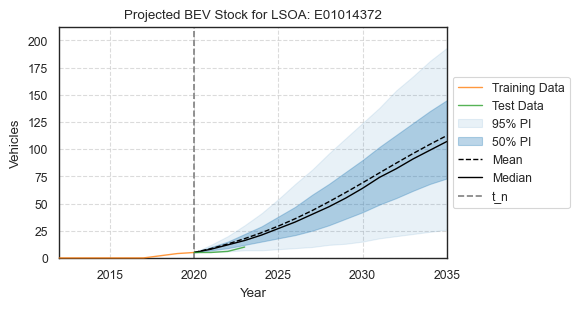

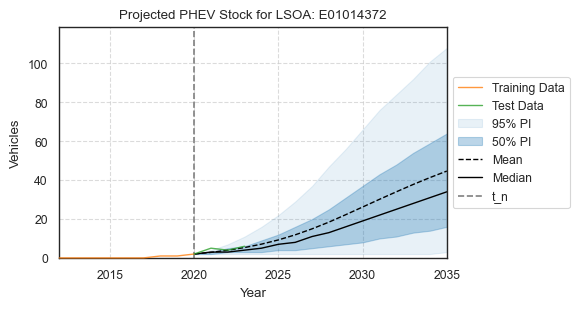

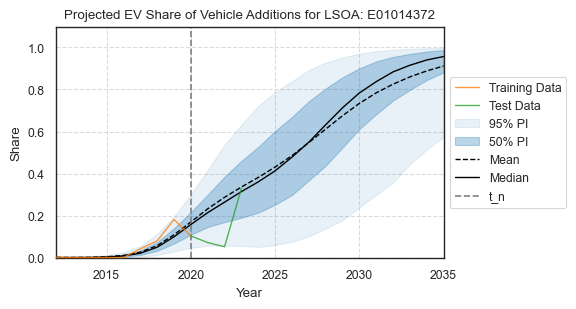

In [1101]:
def plot_forecasts(ev_stock_model, variables):
    for variable_name in variables:
        ev_stock_model.plot_forecast(variable_name=variable_name)

plot_forecasts(
    ev_stock_model=ev_forecasting_model,
    variables=['EV', 'BEV', 'PHEV', 'a']
)

# Experimenting

### Fitting a log-normal distribution to the data

In [1102]:
import scipy.stats as stats

def fit_lognormal(series: pd.Series):
    """
    Fit a log-normal distribution to data stored in a Pandas Series.
    
    Parameters:
        series (pd.Series): The data to fit.

    Returns:
        dict: Dictionary with fitted parameters and distribution.
    """
    data = series.dropna().values  # Remove NaNs if present
    
    # Ensure data contains only strictly positive values
    data = data[data > 0]
    if len(data) == 0:
        raise ValueError("All values are non-positive after filtering. Log-normal distribution requires positive data.")
    
    # Fit a log-normal distribution using MLE
    shape, loc, scale = stats.lognorm.fit(data, floc=0)  # Fix location to 0 for a true log-normal
    
    # Convert to lognormal parameters
    sigma = shape  # Standard deviation of log(X)
    mu = np.log(scale)  # Mean of log(X)

    # Create a fitted distribution
    fitted_dist = stats.lognorm(sigma, loc, scale)

    # Generate values for plotting
    x = np.linspace(min(data), max(data), 100)
    pdf = fitted_dist.pdf(x)  # Probability density function

    # Plot histogram and fitted PDF
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=20, density=True, alpha=0.6, color='b', label="Data Histogram")
    plt.plot(x, pdf, 'r-', lw=2, label="Fitted Log-Normal PDF")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title("Fitted Log-Normal Distribution")
    plt.legend()
    plt.show()

    return {
        "mu": mu,
        "sigma": sigma,
        "scale": scale,
        "fitted_distribution": fitted_dist
    }

def fit_normal(series: pd.Series):
    """
    Fit a normal distribution to data stored in a Pandas Series.
    
    Parameters:
        series (pd.Series): The data to fit.

    Returns:
        dict: Dictionary with fitted parameters and distribution.
    """
    data = series.dropna().values  # Remove NaNs

    # Fit normal distribution using MLE
    mu, sigma = stats.norm.fit(data)

    # Create a fitted normal distribution
    fitted_dist = stats.norm(loc=mu, scale=sigma)

    # Generate values for plotting
    x = np.linspace(min(data), max(data), 100)
    pdf = fitted_dist.pdf(x)  # Probability density function

    # Plot histogram and fitted PDF
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=20, density=True, alpha=0.6, color='b', label="Data Histogram")
    plt.plot(x, pdf, 'r-', lw=2, label="Fitted Normal PDF")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title("Fitted Normal Distribution")
    plt.legend()
    plt.show()

    return {
        "mu": mu,
        "sigma": sigma,
        "fitted_distribution": fitted_dist
    }

def fit_beta(series: pd.Series):
    """
    Fit a beta distribution to data stored in a Pandas Series.

    Parameters:
        series (pd.Series): The data to fit.

    Returns:
        dict: Dictionary with fitted parameters and distribution.
    """
    data = series.dropna().values  # Remove NaNs

    # Ensure data is within the valid range for Beta distribution
    data = np.clip(data, 1e-6, 1 - 1e-6)  # Avoid boundary issues

    # Fit beta distribution using MLE
    alpha, beta, loc, scale = stats.beta.fit(data, floc=0, fscale=1)  # Fix support [0,1]

    # Create a fitted beta distribution
    fitted_dist = stats.beta(alpha, beta, loc=loc, scale=scale)

    # Generate values for plotting
    x = np.linspace(0, 1, 100)
    pdf = fitted_dist.pdf(x)  # Probability density function

    # Plot histogram and fitted PDF
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=20, density=True, alpha=0.6, color='b', label="Data Histogram")
    plt.plot(x, pdf, 'r-', lw=2, label="Fitted Beta PDF")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title("Fitted Beta Distribution")
    plt.legend()
    plt.show()

    return {
        "alpha": alpha,
        "beta": beta,
        "fitted_distribution": fitted_dist
    }

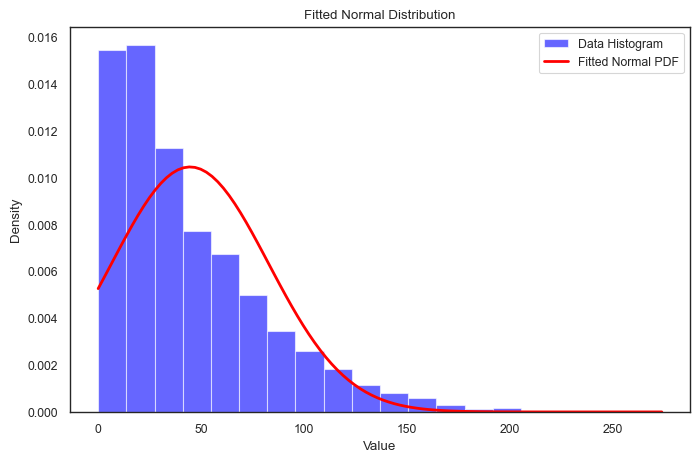

Estimated μ (mean): 44.6636
Estimated σ (std dev): 38.11634341119306


In [1103]:
fit_results = fit_normal(ev_forecasting_model.forecasts['PHEV'].loc[2035])
print(f"Estimated μ (mean): {fit_results['mu']}")
print(f"Estimated σ (std dev): {fit_results['sigma']}")

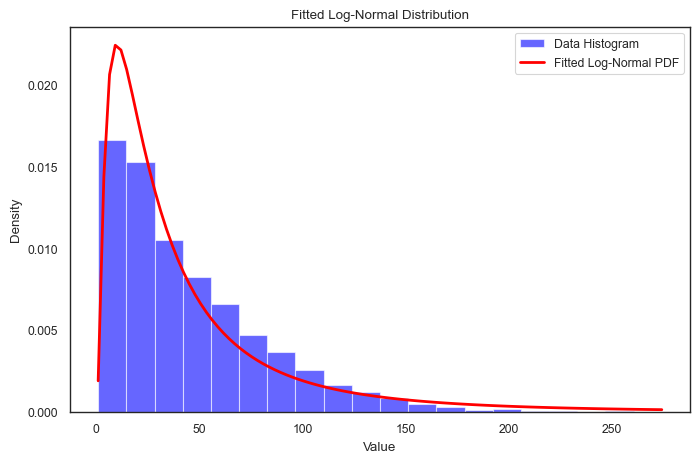

Estimated mean (log mean): 3.377668551608338
Estimated std_dev (log std dev): 1.036392107360343
Estimated scale parameter: 29.30237443885549


In [1104]:
# Fit and plot
fit_results = fit_lognormal(ev_forecasting_model.forecasts['PHEV'].loc[2035])

# Print estimated parameters
print(f"Estimated mean (log mean): {fit_results['mu']}")
print(f"Estimated std_dev (log std dev): {fit_results['sigma']}")
print(f"Estimated scale parameter: {fit_results['scale']}")

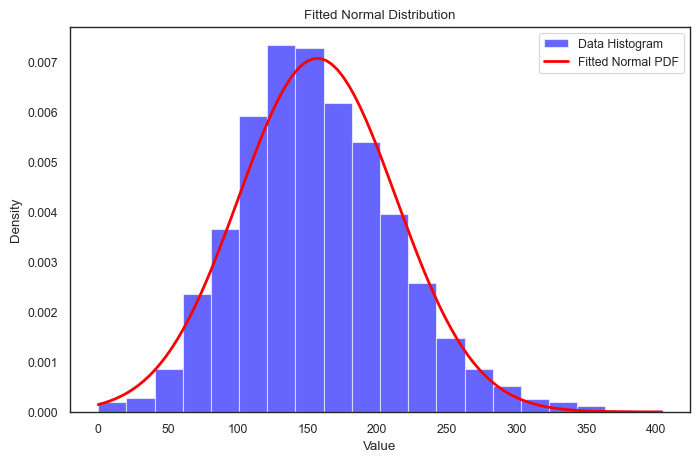

Estimated μ (mean): 157.0902
Estimated σ (std dev): 56.38493827220173


In [1105]:
fit_results = fit_normal(ev_forecasting_model.forecasts['EV'].loc[2035])
print(f"Estimated μ (mean): {fit_results['mu']}")
print(f"Estimated σ (std dev): {fit_results['sigma']}")

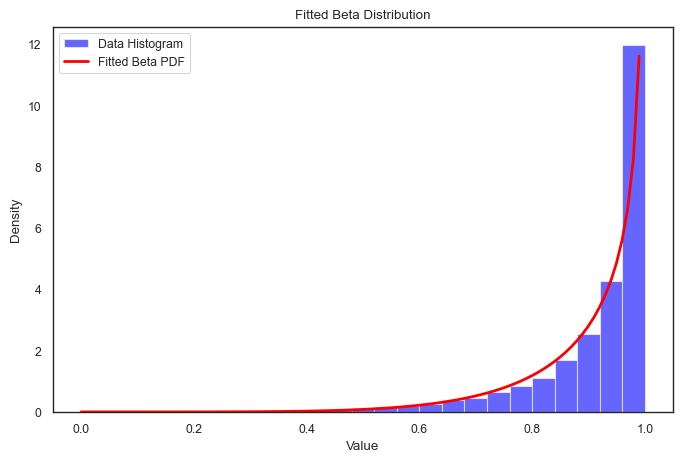

Estimated α (shape1): 5.862550384954415
Estimated β (shape2): 0.5825501475695056


In [1106]:
fit_results = fit_beta(ev_forecasting_model.forecasts['a'].loc[2035])
print(f"Estimated α (shape1): {fit_results['alpha']}")
print(f"Estimated β (shape2): {fit_results['beta']}")

### Evaluating Normality

In [1107]:
def evaluate_normality(series):
    """
    Evaluates the normality of a dataset and determines whether a log-normal transformation is appropriate.
    
    Parameters:
        series (pd.Series): Data to analyze.

    Returns:
        dict: Summary of normality evaluation.
    """
    data = series.dropna().values  # Remove NaNs

    # Compute summary statistics
    mean, median = np.mean(data), np.median(data)
    skewness = stats.skew(data)
    
    # Perform statistical tests
    shapiro_p = stats.shapiro(data)[1] if len(data) <= 5000 else None  # Shapiro-Wilk (only for small samples)
    
    # Evaluate normality
    normality_rejected = (shapiro_p is not None and shapiro_p < 0.05)
    
    # Check for log-normal suitability
    log_normal_suggestion = (skewness > 1 or mean / median > 1.2)
    
    # Plot histogram and Q-Q plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram with normal fit
    sns.histplot(data, kde=True, bins=20, ax=axes[0], color='blue', stat="density")
    x = np.linspace(min(data), max(data), 100)
    axes[0].plot(x, stats.norm.pdf(x, mean, np.std(data)), 'r-', lw=2, label="Normal Fit")
    axes[0].set_title("Histogram with Normal Fit")
    axes[0].legend()

    # Q-Q plot
    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot")

    plt.show()
    
    # Return results
    return {
        "mean": mean,
        "median": median,
        "skewness": skewness,
        "shapiro_p": shapiro_p,
        "normality_rejected": normality_rejected,
        "suggest_log_normal": log_normal_suggestion
    }

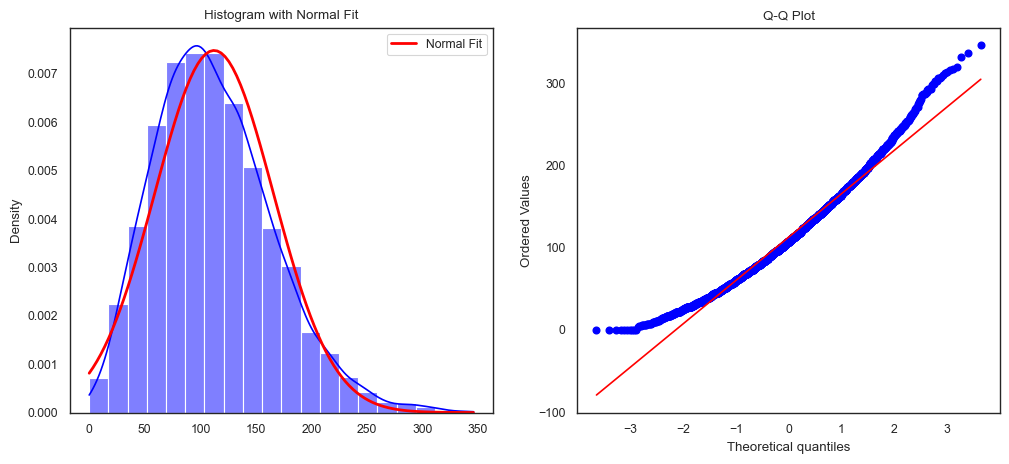

Mean: 112.4202
Median: 107.0
Skewness: 0.6113228085324731
Shapiro-Wilk p-value: 4.0748601390597664e-27
Normality Rejected?: True
Should use Log-Normal?: False


In [1110]:
results = evaluate_normality(ev_forecasting_model.forecasts['BEV'].loc[2035])

print(f"Mean: {results['mean']}")
print(f"Median: {results['median']}")
print(f"Skewness: {results['skewness']}")
print(f"Shapiro-Wilk p-value: {results['shapiro_p']}")
print(f"Normality Rejected?: {results['normality_rejected']}")
print(f"Should use Log-Normal?: {results['suggest_log_normal']}")